In [0]:
import pandas as pd
import requests
import cv2
import glob
import numpy as np
import time
from google.colab import drive
import os
from google.colab.patches import cv2_imshow

In [0]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
df = pd.read_csv("dress_patterns.csv")

In [0]:
os.chdir('./drive/My Drive/greendeck')

In [0]:
class_dict = {}
cnt = 0
for i in df['category']:
  if i not in class_dict:
    class_dict[i] = cnt
    cnt += 1

In [0]:
class_dict

{'OTHER': 8,
 'animal': 7,
 'cartoon': 12,
 'chevron': 13,
 'floral': 4,
 'geometry': 3,
 'houndstooth': 11,
 'ikat': 0,
 'letter_numb': 15,
 'plain': 1,
 'polka dot': 2,
 'scales': 6,
 'skull': 16,
 'squares': 5,
 'stars': 14,
 'stripes': 9,
 'tribal': 10}

In [0]:
new_list = []
for i in df['category']:
  new_list.append(class_dict[i])

In [0]:
df.insert(2,'Class',new_list,True)

In [0]:
df.head()

,_unit_id,category,Class,category:confidence,image_url
0,851505458,ikat,0,0.3487,http://s3-eu-west-1.amazonaws.com/we-attribute...
1,851505459,plain,1,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
2,851505460,polka dot,2,0.6709,http://s3-eu-west-1.amazonaws.com/we-attribute...
3,851505461,plain,1,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
4,851505462,geometry,3,0.7035,http://s3-eu-west-1.amazonaws.com/we-attribute...


Now,let's download our images from their links

In [0]:
for index, row in df.iterrows():
    url = row['image_url']
    uniq_id = row['_unit_id']
    r = requests.get(url, allow_redirects=True)
    if r.status_code == 200:
      open('/content/drive/My Drive/greendeck/images/'+str(uniq_id)+'.png', 'wb').write(r.content)

Since , the images need to be cropped. Calculate bbox coordinates.

In [0]:
def coor(image):
    finale = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i][j] == [0,0,255]).all():
                finale.append([i,j])
    return finale

def crop(img_path):
    img = cv2.imread(img_path)
    cv2_imshow(img)
    coordinates = coor(img)
    if len(coordinates) > 4:
      x,y,w,h = cv2.boundingRect(np.array(coordinates))
      return img[x:x+w,y:y+h]
    else:
      return None

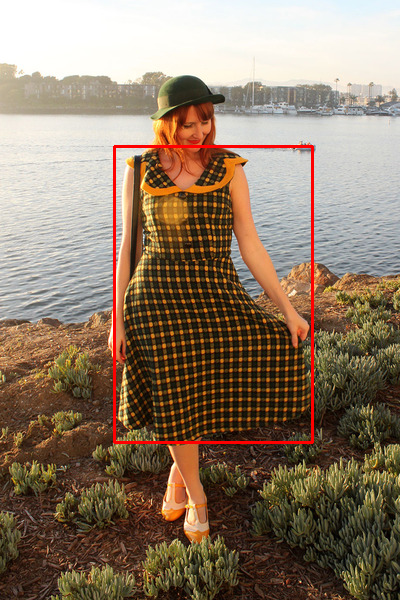

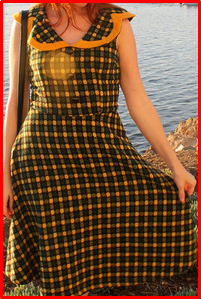

In [0]:
cropped_img = crop('./images/851505460.png')
cv2_imshow(cropped_img)

In [0]:

crop_list = []
class_list = []
cnt = 0
start_time = time.time()
for i in images[1000:2000]:
  
  classy = i.split('/')[-1].split('.')[0]
  if type(crop(i)).__name__ != 'NoneType':
    class_list.append(df.loc[df['_unit_id'] == int(classy)]['Class'].values[0])
    crop_list.append(cv2.resize(crop(i),(224,224)))
  cnt+=1
  if cnt % 100 == 0:
    print(cnt)
  #print(time.time()-start_time)
  

Making Image and label arrays for training the model

In [0]:
import numpy as np
import os
import time
from resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
#from imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('resnet50.py','wb').write(src)

Saving resnet50.py to resnet50 (1).py


12102

compressed_best is all images resized , cropped and in order with their labels , compressed into .npz file

In [0]:
loaded = np.load('compressed_best.npz')
x = loaded['a']
y = loaded['b']

In [0]:
Y = np_utils.to_categorical(y, 17)
X_train, X_test, y_train, y_test = train_test_split(x,Y, test_size=0.2, random_state=2)

Loading my model from resnet50.py and removing last softmax layer and replacing with mine. All layers will be fine tuned while softmax layer will learn from scratch.

In [0]:
num_classes =17
image_input = Input(shape=(224, 224, 3))
model = ResNet50(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()
last_layer = model.get_layer('avg_pool').output
x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=image_input,outputs= out)
custom_resnet_model.summary()

for layer in custom_resnet_model.layers[:-1]:
	layer.trainable = True

custom_resnet_model.layers[-1].trainable

custom_resnet_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint('resnet.hdf5', monitor='val_acc', verbose=0, save_best_only=True)

In [0]:
hist = custom_resnet_model.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test),callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 12539 samples, validate on 3135 samples
Epoch 1/12
12539/12539 [==============================] - 410s 33ms/step - loss: 1.4236 - acc: 0.6654 - val_loss: 2.0949 - val_acc: 0.6507
Epoch 2/12
12539/12539 [==============================] - 390s 31ms/step - loss: 1.3695 - acc: 0.6757 - val_loss: 10.3623 - val_acc: 0.0954
Epoch 3/12
12539/12539 [==============================] - 390s 31ms/step - loss: 1.2554 - acc: 0.6796 - val_loss: 1.3453 - val_acc: 0.6670
Epoch 4/12
12539/12539 [==============================] - 390s 31ms/step - loss: 1.1290 - acc: 0.7105 - val_loss: 1.3521 - val_acc: 0.6494
Epoch 5/12
12539/12539 [==============================] - 390s 31ms/step - loss: 1.0688 - acc: 0.7235 - val_loss: 1.5863 - val_acc: 0.6179
Epoch 6/12
12539/12539 [==============================] - 391s 31ms/step - loss: 1.0250 - acc: 0.7307 - val_loss: 1.4590 - val_acc: 0.6022
Epoch 7/12
12539/12539 [==============================] - 390s 31ms/

In [0]:
(loss, accuracy) = custom_resnet_model.evaluate(X_test, y_test, batch_size=10, verbose=1)


3135/3135 [==============================] - 36s 11ms/step


In [0]:
print(loss,accuracy)

1.4194780405153309 0.6555023964322164


Lets terminate our training, model would have converged more but lets settle for this now.

To test the model open 'predict.pynb'